In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 33.0 MB 1.2 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.11.23 which is incompatible.


# 1. Data Preprocessing
In this stage, the faces part of each sample are extracted and store into /data/ folder for the consecutive procedures.

This was done in local before uploading to drive due to easy management.

First Attempt: Using OpenCV with Haarcascade model to extract the face from the sample. However, it was NOT used due to low accuracy.

False

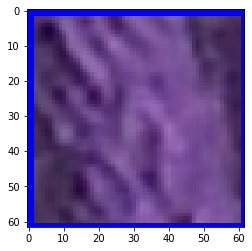

In [3]:
#### NOT BEING USED ####
import cv2
import matplotlib.pyplot as plt


def crop_face_not_used(file, direcotry):

    img = cv2.imread(file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    # List of faces found
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
        face = img[y:y + h, x:x + w]
        #cv2.imshow('face', face)
        plt.imshow(face)
        #cv2.imwrite('face.jpg', face)
    # Display and store the output
    #cv2.imwrite('detcted.jpg', img)
    #plt.imshow(img)
    return False


path_of_the_directory= ''
# Example of inaccurate pixels extracted
crop_face_not_used(path_of_the_directory+'/content/gdrive/MyDrive/COMP4211 Project/dataset/1/pra3.jpg',None)


Second attempt: Using MediaPipe model to extract the faces. (High accuracy)

In [4]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

mp_face_detection = mp.solutions.face_detection

# Face extraction function
def crop_face(file):
    global mp_face_detection
    
    # Load the model
    face_detection = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)
    
    image = cv2.imread(file)
    height, width, channels = image.shape
    
    # Fetch the result of faces
    results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # If faces cannot be extracted, use the original image as the result of extraction
    if not results.detections:
        return image

    for detection in results.detections:
        # Get the location of x and y coordinate, following with the width and height of the face extracted
        x_min = max(0, int(detection.location_data.relative_bounding_box.xmin * width))
        y_min = max(0, int(detection.location_data.relative_bounding_box.ymin * height))
        _width = min(width, int(detection.location_data.relative_bounding_box.width * width))
        _height = min(height, int(detection.location_data.relative_bounding_box.height * height))
        # Return the pixels containing the faces
        face = image[y_min:y_min + _height, x_min:x_min + _width]
        return face
    # Wont reach here, in case unexpected error happen, returning the original image
    return image


Read the images from /dataset/, and do the extraction to all samples, storing the results to /data/ for model training and evaluation.

It cannot run in collab because of the incomplete path. It was done in local directory and uploaded to google drive

In [5]:
import os
import csv
import cv2
import random

dataset_path = './dataset/'

# Make directories of the cropped data
if not os.path.exists('./data/'):
    os.mkdir('./data/')
if not os.path.exists('./data/train/'):
    os.mkdir('./data/train/')
if not os.path.exists('./data/valid/'):
    os.mkdir('./data/valid/')
if not os.path.exists('./data/test/'):
    os.mkdir('./data/test/')

# Non-Masked Face
dataset_path_non_masked = dataset_path +'0/'
num_of_sample = len(os.listdir(dataset_path_non_masked))

# Dividing the dataset into training set, validation set and test set,
# with proportion 80%, 10% and 10% respectively.
valid_size = (int) (num_of_sample * 0.1)
test_size = (int) (num_of_sample * 0.1)
train_size = num_of_sample - valid_size - test_size

if not os.path.exists('./data/train/0/'):
    os.mkdir('./data/train/0/')
if not os.path.exists('./data/valid/0/'):
    os.mkdir('./data/valid/0/')
if not os.path.exists('./data/test/0/'):
    os.mkdir('./data/test/0/')
    
for file in os.listdir(dataset_path_non_masked):
    f = os.path.join(dataset_path_non_masked,file)
    # Divide data set
    rand = random.uniform(0, 1.0)

    if rand < 0.1 and valid_size > 0:
        face = crop_face(f)
        cv2.imwrite('./data/valid/0/'+file,face)
        valid_size -= 1
    elif rand < 0.2 and test_size > 0:
        face = crop_face(f)
        cv2.imwrite('./data/test/0/'+file,face)
        test_size -= 1
    else:
        if train_size > 0:
            face = crop_face(f)
            cv2.imwrite('./data/train/0/'+file,face)
            train_size -= 1
        elif valid_size > 0:
            face = crop_face(f)
            cv2.imwrite('./data/valid/0/'+file,face)
            valid_size -= 1
        else:
            face = crop_face(f)
            cv2.imwrite('./data/test/0/'+file,face)
            test_size -= 1

# Masked Face
dataset_path_masked = dataset_path +'1/'
num_of_sample = len(os.listdir(dataset_path_masked))
valid_size = (int) (num_of_sample * 0.1)
test_size = (int) (num_of_sample * 0.1)
train_size = num_of_sample - valid_size - test_size

if not os.path.exists('./data/train/1/'):
    os.mkdir('./data/train/1/')
if not os.path.exists('./data/valid/1/'):
    os.mkdir('./data/valid/1/')
if not os.path.exists('./data/test/1/'):
    os.mkdir('./data/test/1/')
    
for file in os.listdir(dataset_path_masked):
    f = os.path.join(dataset_path_masked,file)
    # Divide data set
    rand = random.uniform(0, 1.0)

    if rand < 0.1 and valid_size > 0:
        face = crop_face(f)
        cv2.imwrite('./data/valid/1/'+file,face)
        valid_size -= 1
    elif rand < 0.2 and test_size > 0:
        face = crop_face(f)
        cv2.imwrite('./data/test/1/'+file,face)
        test_size -= 1
    else:
        if train_size > 0:
            face = crop_face(f)
            cv2.imwrite('./data/train/1/'+file,face)
            train_size -= 1
        elif valid_size > 0:
            face = crop_face(f)
            cv2.imwrite('./data/valid/1/'+file,face)
            valid_size -= 1
        else:
            face = crop_face(f)
            cv2.imwrite('./data/test/1/'+file,face)
            test_size -= 1

FileNotFoundError: ignored

# 2. Model Implementation and training

In [15]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory('/content/gdrive/MyDrive/COMP4211 Project/data/train', 
                                                    batch_size=10, 
                                                    target_size=(150, 150), class_mode='binary')

valid_datagen = ImageDataGenerator(rescale=1.0/255)
valid_generator = valid_datagen.flow_from_directory('/content/gdrive/MyDrive/COMP4211 Project/data/valid', 
                                                         batch_size=10, 
                                                         target_size=(150, 150), class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory('/content/gdrive/MyDrive/COMP4211 Project/data/test', 
                                                         batch_size=10, 
                                                         target_size=(150, 150), class_mode='binary', shuffle=False)

Found 1102 images belonging to 2 classes.
Found 137 images belonging to 2 classes.
Found 137 images belonging to 2 classes.


In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from keras.callbacks import ModelCheckpoint

# Building sequential model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(2, activation='softmax')
])

checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/COMP4211 Project/best_model.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.fit(train_generator, epochs=10, validation_data = valid_generator, callbacks=[checkpoint])

Epoch 1/10
111/111 [==============================] - ETA: 0s - loss: 0.3407 - acc: 0.8203

111/111 [==============================] - 195s 2s/step - loss: 0.3407 - acc: 0.8203 - val_loss: 0.0373 - val_acc: 0.9854
Epoch 2/10
111/111 [==============================] - ETA: 0s - loss: 0.1120 - acc: 0.9701

111/111 [==============================] - 9s 84ms/step - loss: 0.1120 - acc: 0.9701 - val_loss: 0.0211 - val_acc: 0.9927
Epoch 3/10
111/111 [==============================] - 8s 72ms/step - loss: 0.1362 - acc: 0.9519 - val_loss: 0.0757 - val_acc: 0.9635
Epoch 4/10
111/111 [==============================] - ETA: 0s - loss: 0.1785 - acc: 0.9365

111/111 [==============================] - 9s 85ms/step - loss: 0.1785 - acc: 0.9365 - val_loss: 0.0131 - val_acc: 0.9927
Epoch 5/10
111/111 [==============================] - ETA: 0s - loss: 0.1281 - acc: 0.9555

111/111 [==============================] - 10s 87ms/step - loss: 0.1281 - acc: 0.9555 - val_loss: 0.0076 - val_acc: 1.0000
Epoch 6/10
111/111 [==============================] - 8s 72ms/step - loss: 0.0731 - acc: 0.9791 - val_loss: 0.0168 - val_acc: 0.9927
Epoch 7/10
111/111 [==============================] - ETA: 0s - loss: 0.0867 - acc: 0.9737

111/111 [==============================] - 9s 85ms/step - loss: 0.0867 - acc: 0.9737 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 8/10
111/111 [==============================] - 8s 72ms/step - loss: 0.0750 - acc: 0.9764 - val_loss: 0.0402 - val_acc: 0.9854
Epoch 9/10
111/111 [==============================] - ETA: 0s - loss: 0.0888 - acc: 0.9637

111/111 [==============================] - 9s 84ms/step - loss: 0.0888 - acc: 0.9637 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 10/10
111/111 [==============================] - 8s 73ms/step - loss: 0.0678 - acc: 0.9791 - val_loss: 0.1724 - val_acc: 0.8978


In [8]:

model.evaluate(test_generator)
model.summary()

14/14 [==============================] - 32s 2s/step - loss: 0.0985 - acc: 0.9416
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  import sys


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1]


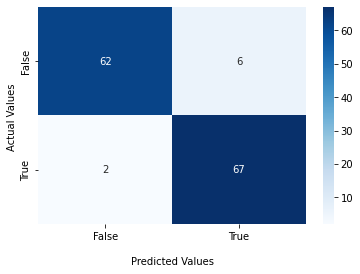

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.


  Accuracy:  0.9416058659553528


In [16]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predict result and True result of the test generator
result = model.predict_generator(test_generator, verbose=0)
y_true = test_generator.classes
y_pred = np.argmax(result,axis=1)
print(y_true)
print(y_pred)

# Confusion map
cm = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

# Accuracy
loss, acc = model.evaluate_generator(test_generator, verbose=0)
print("  Accuracy: ", acc)